In [1]:
import pdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from itertools import compress
from math import floor

In [2]:
data = pd.read_csv('train_data.csv')

In [3]:
feature_names = data.columns
feature_names = [i for i in feature_names if i not in ['Survived', 'Unnamed: 0']]

X = data[feature_names]
y = data['Survived']

### General Methods

In [4]:
def k_fold_split(X_train, k=5):
    #
    valid_rows = [0]*10
    train_rows = [0]*10
    
    size = floor(X_train.shape[0]/k)
    all_train_rows_orig = list(pd.Series(range(X_train.shape[0])))
    remaining_valid_rows = all_train_rows_orig
    
    for i in range(k):
        if i != (k-1):
            valid_rows[i] = random.sample(remaining_valid_rows, size)
            train_rows[i] = [r for r in all_train_rows_orig if r not in valid_rows[i]]
            remaining_valid_rows = [r for r in remaining_valid_rows if r not in valid_rows[i]]
        
        if i == (k-1):
            valid_rows[k-1] = remaining_valid_rows
            train_rows[k-1] = [r for r in all_train_rows_orig if r not in valid_rows[k-1]]
            
    return(train_rows, valid_rows)

In [5]:
def get_AUC(y_pred, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    return(auc(fpr, tpr))

### GA Methods

In [6]:
def genome_pop(n, size):
    #produce n genomes of length size
    #returns a list
    
    population_set = []
    theoretical_population_set = 2**size
    
    for i in range(n):
        genome_int = random.randint(1,theoretical_population_set)
        genome_bin = bin(genome_int)
        genome_list = list(str(genome_bin)[2:])
        
        if(len(genome_list) < size):
            missing = size - len(genome_list)
            genome_list = list(np.zeros(missing)) + genome_list
        genome_list = [int(x) for x in genome_list]
        population_set.append(genome_list)
    
    return(population_set)
        

In [7]:
def feature_select(feature_names, genome):
    #converts genome to feature set
    return(list(compress(feature_names, genome)))

In [8]:
def fit_and_score(X_train, y_train, X_valid, y_valid, features):
    #Fit model with 'features' on train set, get performance on validation set
    #return performance on validation set
    
    #select feature subset to be tested
    tmp_train = X_train[features]
    tmp_valid = X_valid[features]
    
    
    tmp_lgr = LogisticRegression(solver='liblinear')
    tmp_lgr.fit(X=tmp_train, y = y_train)
    
    y_pred_train = tmp_lgr.predict(tmp_train)
    y_pred_valid = tmp_lgr.predict(tmp_valid)
    
    train_score = get_AUC(y_pred_train, y_train)
    valid_score = get_AUC(y_pred_valid, y_valid)
    
    return(train_score, valid_score)

In [9]:
def fitness_assessment(population, X_train, y_train, X_valid, y_valid, selective_pressure = 1.5):
    train_score_pop = []
    valid_score_pop = []
    
    #for each gene assess fitness on train and validation sets
    #append results
    for i in range(len(population)):
        tmp_gene = population[i]
        tmp_genomic_features = feature_select(feature_names, tmp_gene)
        train_score, valid_score = fit_and_score(X_train, y_train, X_valid, y_valid, tmp_genomic_features )
        train_score_pop.append(train_score)
        valid_score_pop.append(valid_score)
    
    #Construct ordered table of results
    population_fitness_results = pd.DataFrame(pd.Series(valid_score_pop, name = "validation_score"))
    population_fitness_results['ID'] = population_fitness_results.index
    population_fitness_results.sort_values(by=['validation_score'],
                                   inplace = True,
                                  ascending = True)
    population_fitness_results.reset_index(drop = True, inplace = True)
    population_fitness_results['Rank'] = population_fitness_results.index + 1
    population_fitness_results['Fitness'] = selective_pressure * population_fitness_results['Rank']
    population_fitness_results.sort_values(by=['Fitness'], 
                                          inplace = True,
                                          ascending=False)
    return(population_fitness_results)

In [10]:
def genetic_selection(gene_pool, fitness_frame, elitism = 2, winner_frac = 0.5):
    
    #Get number of winners
    entrants = fitness_frame.shape[0]
    winner_count = floor(entrants * winner_frac) - elitism
    
    #Deterministically select top few
    #elitism_selected = list(fitness_frame['ID'][0:elitism])
    elitism_selected = list(fitness_frame.loc[range(elitism),'ID'])
    #remove top few from genetic lottery
    genetic_lottery_set = fitness_frame.iloc[elitism:fitness_frame.shape[0]].copy()
    genetic_lottery_set.loc[:,'point_mass'] = genetic_lottery_set.loc[:,'Fitness'] / genetic_lottery_set.loc[:,'Fitness'].sum()
    
    #conduct genetic lottery
    genetic_lottery_winners = genetic_lottery_set.sample(n = winner_count,
                                                        replace = False,
                                                        weights = genetic_lottery_set['point_mass'])
    
    
    winner_ids = list(genetic_lottery_winners['ID']) + elitism_selected
    
    
    return(winner_ids)

In [11]:
#gene swap
def gene_swap(a,b,n, seed = ""):
    
    offspring = []
    for i in range(n):
        c = []
        for i in range(len(a)):
            if seed != "":
                random.seed(seed)
                coin = random.uniform(0,1)
            else:
                coin = random.uniform(0,1)
                
            if((a[i]==1) & (b[i] ==1)):
                gene_val = 1

            if( (a[i]==1) & (b[i] ==0)):
                
                if(coin > 0.5):
                    gene_val = 1
                if(coin <= 0.5):
                    gene_val = 0

            if( (a[i] == 0) & (b[i] == 1)):
                if(coin > 0.5):
                    gene_val = 1
                else:
                    gene_val = 0

            if( (a[i] == 0) & (b[i] == 0)):
                gene_val = 0
                
            c.append(gene_val)
        offspring.append(c)
    
    return(offspring)

In [12]:
def generation_metrics(fitness):
    #overall mean
    ov_mean = fitness['validation_score'].mean()
    #overall median
    ov_median = fitness['validation_score'].median()
    #overall best
    ov_max = fitness['validation_score'].max()
    #overall worst
    ov_min = fitness['validation_score'].min()
    #median of top 10
    top_10_med = fitness.iloc[0:9]['validation_score'].median()
    #mean of top 10
    top_10_mean = fitness.iloc[0:9]['validation_score'].mean()
    
    metrics = {
        'Overall_Mean': ov_mean,
        'Overall_Median': ov_median,
        'Overall_Max': ov_max,
        'Overall_Min': ov_min,
        'Top_10_Median': top_10_med,
        'Top_10_Mean': top_10_mean
    }
    
    return(metrics)

### Tests

In [13]:
def gene_swap_tests():
    #Test Zeros
    a = [0]
    b = [0]
    assert gene_swap(a, b, 1, 42) == [[0]]
    assert gene_swap(a, b, 2, 42) == [[0], [0]]
    assert gene_swap(a, b, 5, 42) == [[0], [0], [0], [0], [0]]
    
    a = [0, 0]
    b = [0, 0]
    assert gene_swap(a, b, 1, 42) == [[0,0]]
    assert gene_swap(a, b, 2, 42) == [[0,0],[0,0]]
    assert gene_swap(a, b, 5, 42) == [[0,0],[0,0],[0,0],[0,0],[0,0]]
    
    a = [0, 0, 0, 0, 0]
    b = [0, 0, 0, 0, 0]
    assert gene_swap(a, b, 1, 42) == [[0, 0, 0, 0, 0]]
    assert gene_swap(a, b, 2, 42) == [[0, 0, 0, 0, 0],[0, 0, 0, 0, 0]]
    assert gene_swap(a, b, 5, 42) == [[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0]]
    
    #Test Ones
    a = [1]
    b = [1]
    assert gene_swap(a, b, 1, 42) == [[1]]
    assert gene_swap(a, b, 2, 42) == [[1], [1]]
    assert gene_swap(a, b, 5, 42) == [[1], [1], [1], [1], [1]]
    
    a = [1, 1]
    b = [1, 1]
    assert gene_swap(a, b, 1, 42) == [[1, 1]]
    assert gene_swap(a, b, 2, 42) == [[1, 1],[1, 1]]
    assert gene_swap(a, b, 5, 42) == [[1, 1],[1, 1],[1, 1],[1, 1],[1, 1]]
    
    a = [1, 1, 1, 1, 1]
    b = [1, 1, 1, 1, 1]
    assert gene_swap(a, b, 1, 42) == [[1, 1, 1, 1, 1]]
    assert gene_swap(a, b, 2, 42) == [[1, 1, 1, 1, 1],[1, 1, 1, 1, 1]]
    assert gene_swap(a, b, 5, 42) == [[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1]]
    
    
    print("--Pass--")

In [14]:
gene_swap_tests()

--Pass--


In [15]:
def mutation(generation, mutation_rate):
    #each gene is mutated with probability mutation_rate
    for i in range(len(generation)):
        for j in range(len(generation[i])):
            coin = random.uniform(0,1)
            if coin <= mutation_rate:
                #invert gene
                generation[i][j] = int(( not bool(generation[i][j]) ) * 1.0)
    
    return (generation)
                

In [16]:
def viability_check(generation):
    #require that each genome has at least 1 gene turned on
    for i in range(len(generation)):
        if sum(generation[i]) == 0:
            generation[i][random.randint(0,len(generation[i])-1)] = 1
    
    return(generation)

In [17]:
def crossover(current_gen, offspring_count = 4, replacement_rate = 2, mutation_rate = .05):
    #choose 2 without replacement
    #create 4 offspring with mutation rate
    #continue until population is replaced
    #return mutated set
    next_gen = []
    
    schedule = generation_scheme(len(current_gen), offspring_count)
    
    #use schedule to call gene_swap
    for i in range(schedule.shape[0]):
        parent_a = current_gen[schedule.iloc[i]['Parent_A']]
        parent_b = current_gen[schedule.iloc[i]['Parent_B']]
        offspring = schedule.iloc[i]['Offspring']
        
        offspring_set = gene_swap(a=parent_a, b=parent_b, n=offspring)
        next_gen = next_gen + offspring_set
        #next_gen_mutated = mutation(next_gen, mutation_rate)
    #once results from gene_swap are complete, then call mutate
    next_gen_mutated = mutation(next_gen, mutation_rate)
    #require certain standards
    next_gen_mutated_viable = viability_check(next_gen_mutated)
    return(next_gen_mutated_viable)

In [18]:
def generation_scheme(current_gen_count, offspring, replacement_rate = 2):
    #returns parent IDs and child count for replacement    
    standard_rounds = floor(current_gen_count * 2 / offspring)
    if(standard_rounds != (current_gen_count * 2 / offspring) ):
        extra_round = 1
    else:
        extra_round = 0
    
    final_round_offspring = current_gen_count*2 - (standard_rounds * offspring)
    
    current_gen = list(range(0,current_gen_count))
    parent_A = pd.Series(random.sample(current_gen, standard_rounds + extra_round), name = "Parent_A")
    remaining = [i for i in current_gen if i not in parent_A]
    parent_B = pd.Series(random.sample(remaining, standard_rounds + extra_round), name="Parent_B")
    
    child_schedule = pd.Series(([offspring] * standard_rounds) + ([final_round_offspring] * extra_round), name = "Offspring")
    
    offspring_schedule = pd.DataFrame([parent_A, parent_B, child_schedule])
    
    return(offspring_schedule.transpose())    

General Algorithm:
1.  K-fold split (Hyp: k)
2.  Randomly generate some random genome (Hyp: population size)
3.  Assess fitness of each (Param: Fitness metric)
4.  Method for 'genetic propagation' (Hyp: # Elitism metrics)
    4a.  How many survive based on ranking
    4b.  How many survive randomly
    4c.  Mutation probability
    4d.  Pairing probability
5.  Repeat process (Hyp: # of times to repeat process)


In [19]:
test_gen = genome_pop(100,15)
tmp_genomic_features = feature_select(feature_names, test_gen)

train_sets, valid_sets = k_fold_split(X, 5)

X.loc[train_sets[0],]

tmp_Xtrain = X.iloc[train_sets[0],]
tmp_ytrain = y[train_sets[0]]
tmp_Xvalid = X.iloc[valid_sets[0],]
tmp_yvalid = y[valid_sets[0]]

In [143]:
def halloffame(n, new_fitness, generation, oldhalloffame):
    hof_new = new_fitness.iloc[0:10].loc[:,["ID","validation_score"]].copy()
    hof_new['gene'] = hof_new['ID'].apply(lambda x: generation[x])
    
    if oldhalloffame.shape[0] != 0:
        next_hof = oldhalloffame.append(hof_new).sort_values(by = "validation_score", ascending = False).iloc[0:10]
    else:
        next_hof = hof_new
    
    return(next_hof)
        

In [144]:
def GA(generation, X_train, y_train, X_valid, y_valid, nrounds=50, elitism=2, winner_frac=0.5, offspring_count = 4, mutation_rate=.01):
    metrics = []
    hof = pd.DataFrame()
    for i in range(nrounds):
        print('Generation: ' + str(i+1), end= '\r')
        #assess generation's fitness
        tmp_fitness = fitness_assessment(generation, X_train, y_train, X_valid, y_valid)
        hof = halloffame(n=10, 
                                new_fitness=tmp_fitness, 
                                generation=generation, 
                                oldhalloffame=hof)
        #Save some metrics of generation's fitness
        tmp_metrics = generation_metrics(tmp_fitness)
        metrics.append(tmp_metrics)
        #Select winners of genetic lottery
        tmp_winner_ids = genetic_selection(generation, tmp_fitness, elitism, winner_frac)
        #convert winner ids into list of actual winning genes
        tmp_winner_pop = [generation[i] for i in tmp_winner_ids]
        #get next generation
        generation = crossover(current_gen = tmp_winner_pop, 
                               offspring_count = offspring_count,
                               replacement_rate = 2,
                               mutation_rate = mutation_rate)
    
    tmp_fitness = fitness_assessment(generation, X_train, y_train, X_valid, y_valid)
    return(generation, tmp_fitness, metrics, hof)
    

In [226]:
fitness.head()

,validation_score,ID,Rank,Fitness
99,0.844009,99,100,150.0
98,0.844009,54,99,148.5
97,0.844009,28,98,147.0
96,0.844009,29,97,145.5
95,0.844009,31,96,144.0


### Main

In [181]:
#Read in data
data = pd.read_csv('train_data.csv')

In [211]:
data.head()

,Unnamed: 0,PassengerId,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Family_size,Title_1,Title_2,Title_3,Title_4,Emb_1,Emb_2,Emb_3,AgeTimesFare
0,0,1,0,1,0.2750,0.014151,0,0,1,0.1,1,0,0,0,0,0,1,0.003892
1,1,2,1,0,0.4750,0.139136,1,0,0,0.1,1,0,0,0,1,0,0,0.066089
2,2,3,1,0,0.3250,0.015469,0,0,1,0.0,0,0,0,1,0,0,1,0.005027
3,3,4,1,0,0.4375,0.103644,1,0,0,0.1,1,0,0,0,0,0,1,0.045344
4,4,5,0,1,0.4375,0.015713,0,0,1,0.0,1,0,0,0,0,0,1,0.006874


In [212]:
#Perform feature engineering:
data['AgeTimesFare'] = data['Age'] * data['Fare']
data['AgeTimesSex'] = data['Age'] * data['Sex']
data['AgeTimesC1'] = data['Age'] * data['Pclass_1']

In [213]:
feature_names = data.columns
feature_names = [i for i in feature_names if i not in ['Survived', 'Unnamed: 0']]
feature_enc = len(feature_names)

X = data[feature_names]
y = data['Survived']

In [227]:
test_gen = genome_pop(100,feature_enc)
tmp_genomic_features = feature_select(feature_names, test_gen)

train_sets, valid_sets = k_fold_split(X, 5)

X.loc[train_sets[0],]

tmp_Xtrain = X.iloc[train_sets[0],]
tmp_ytrain = y[train_sets[0]]
tmp_Xvalid = X.iloc[valid_sets[0],]
tmp_yvalid = y[valid_sets[0]]


last_gen, fitness, metrics, hof = GA(generation = test_gen,
                               X_train=tmp_Xtrain,
                               y_train = tmp_ytrain,
                               X_valid = tmp_Xvalid,
                               y_valid = tmp_yvalid,
                               nrounds=100,
                               elitism=2,
                               winner_frac=0.5,
                               offspring_count=4,
                               mutation_rate=.01)

In [215]:
HOF = hof['gene'].apply(lambda x: feature_select(feature_names, x))

In [223]:
fitness

,validation_score,ID,Rank,Fitness
99,0.844009,99,100,150.0
98,0.844009,54,99,148.5
97,0.844009,28,98,147.0
96,0.844009,29,97,145.5
95,0.844009,31,96,144.0
94,0.844009,32,95,142.5
93,0.844009,33,94,141.0
92,0.844009,36,93,139.5
91,0.844009,37,92,138.0
90,0.844009,38,91,136.5


In [222]:
HOF.iloc[0]

['PassengerId',
 'Sex',
 'Age',
 'Fare',
 'Family_size',
 'Title_1',
 'Title_3',
 'Title_4',
 'Emb_1',
 'Emb_2',
 'AgeTimesSex',
 'AgeTimesC1']

In [220]:
HOF.apply(lambda x: 'AgeTimesC1' in x)

99     True
99    False
99    False
99    False
99    False
99    False
99    False
99    False
98    False
99    False
Name: gene, dtype: bool

In [218]:
mean_results = [metrics[i]["Overall_Mean"] for i in range(len(metrics))]
median_results = [metrics[i]["Overall_Median"] for i in range(len(metrics))]
OverallMax_results = [metrics[i]["Overall_Max"] for i in range(len(metrics))]
OverallMin_results = [metrics[i]["Overall_Min"] for i in range(len(metrics))]
gen_index = [i for i in range(len(metrics))]

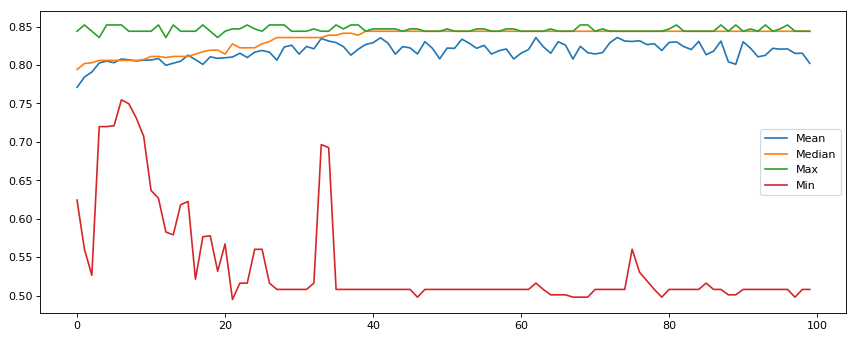

In [219]:
plt.figure(figsize=(13, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(gen_index, mean_results)
plt.plot(gen_index, median_results)
plt.plot(gen_index, OverallMax_results)
plt.plot(gen_index, OverallMin_results)
plt.legend(['Mean', 'Median', 'Max', 'Min'])
plt.show()

In [72]:
fit_and_score(tmp_Xtrain, tmp_ytrain, tmp_Xvalid, tmp_yvalid, feature_select(feature_names, last_gen[99]))

(0.797156566926494, 0.8040816326530612)